****************************Predicting Restaurant Food Cost***************************************************** 


Investigate the factors that really affect the food cost in restaurants, and who knows maybe you will even gain some very interesting insights that might help you choose what to eat and from where.

Size of training set: 12,690 records

Size of test set: 4,231 records

Features:
TITLE: The feature of the restaurant which can help identify what and for whom it is suitable for.

RESTAURANT_ID: A unique ID for each restaurant.

CUISINES: The variety of cuisines that the restaurant offers.

TIME: The open hours of the restaurant.

CITY: The city in which the restaurant is located.

LOCALITY: The locality of the restaurant.

RATING: The average rating of the restaurant by customers.

VOTES: The overall votes received by the restaurant.

COST: The average cost of a two-person meal.

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import KFold
from math import sqrt 
from sklearn.metrics import mean_squared_log_error

In [2]:
fdc_train=pd.read_excel('Data_Train.xlsx')
fdc_test=pd.read_excel('Data_Test.xlsx')

In [3]:
fdc_train.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300


In [4]:
fdc_test.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES
0,CASUAL DINING,4085,"North Indian, Chinese, Mughlai, Kebab",12noon – 12midnight (Mon-Sun),Noida,Sector 18,4.3,564 votes
1,QUICK BITES,12680,"South Indian, Fast Food, Pizza, North Indian",7am – 12:30AM (Mon-Sun),Mumbai,Grant Road,4.2,61 votes
2,CASUAL DINING,1411,"North Indian, Seafood, Biryani, Chinese",11am – 11:30pm (Mon-Sun),Mumbai,Marine Lines,3.8,350 votes
3,None,204,Biryani,"9am – 10pm (Mon, Wed, Thu, Fri, Sat, Sun), 10:...",Faridabad,NIT,3.8,1445 votes
4,QUICK BITES,13453,"South Indian, Kerala",11am – 10pm (Mon-Sun),Kochi,Kaloor,3.6,23 votes


In [5]:
# Get a count of unique values in train dataset.
for col in fdc_train.columns:
    print("Count of unique values in", col, fdc_train[col].nunique())

Count of unique values in TITLE 113
Count of unique values in RESTAURANT_ID 11892
Count of unique values in CUISINES 4155
Count of unique values in TIME 2689
Count of unique values in CITY 359
Count of unique values in LOCALITY 1416
Count of unique values in RATING 32
Count of unique values in VOTES 1847
Count of unique values in COST 86


In [6]:
# Get a count of unique values in test dataset.
for col in fdc_test.columns:
    print("Count of unique values in", col, fdc_test[col].nunique())

Count of unique values in TITLE 86
Count of unique values in RESTAURANT_ID 4127
Count of unique values in CUISINES 1727
Count of unique values in TIME 1183
Count of unique values in CITY 151
Count of unique values in LOCALITY 834
Count of unique values in RATING 31
Count of unique values in VOTES 1136


In [7]:
# Let;s check the shape of the train and test dataset. 
fdc_train.shape, fdc_test.shape

((12690, 9), (4231, 8))

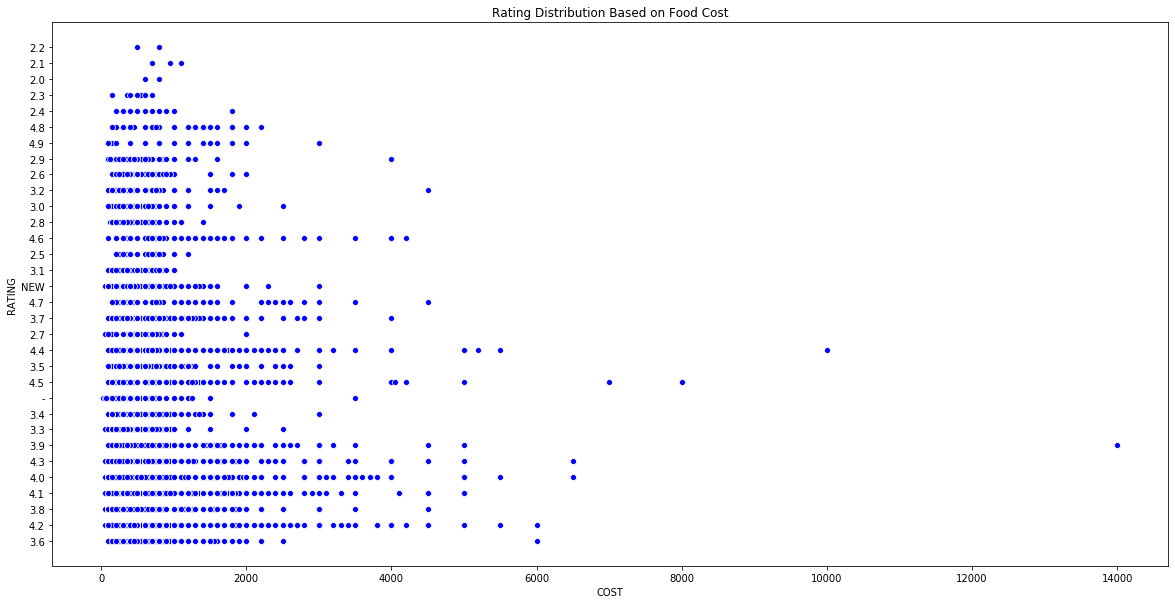

In [8]:
# Let's see how rating varies with the price 
fig, ax = plt.subplots(figsize=(20, 10))  
sns.scatterplot(y='RATING', x='COST', data=fdc_train, ax=ax, color='blue')  
ax.set_title('Rating Distribution Based on Food Cost')  
plt.show()

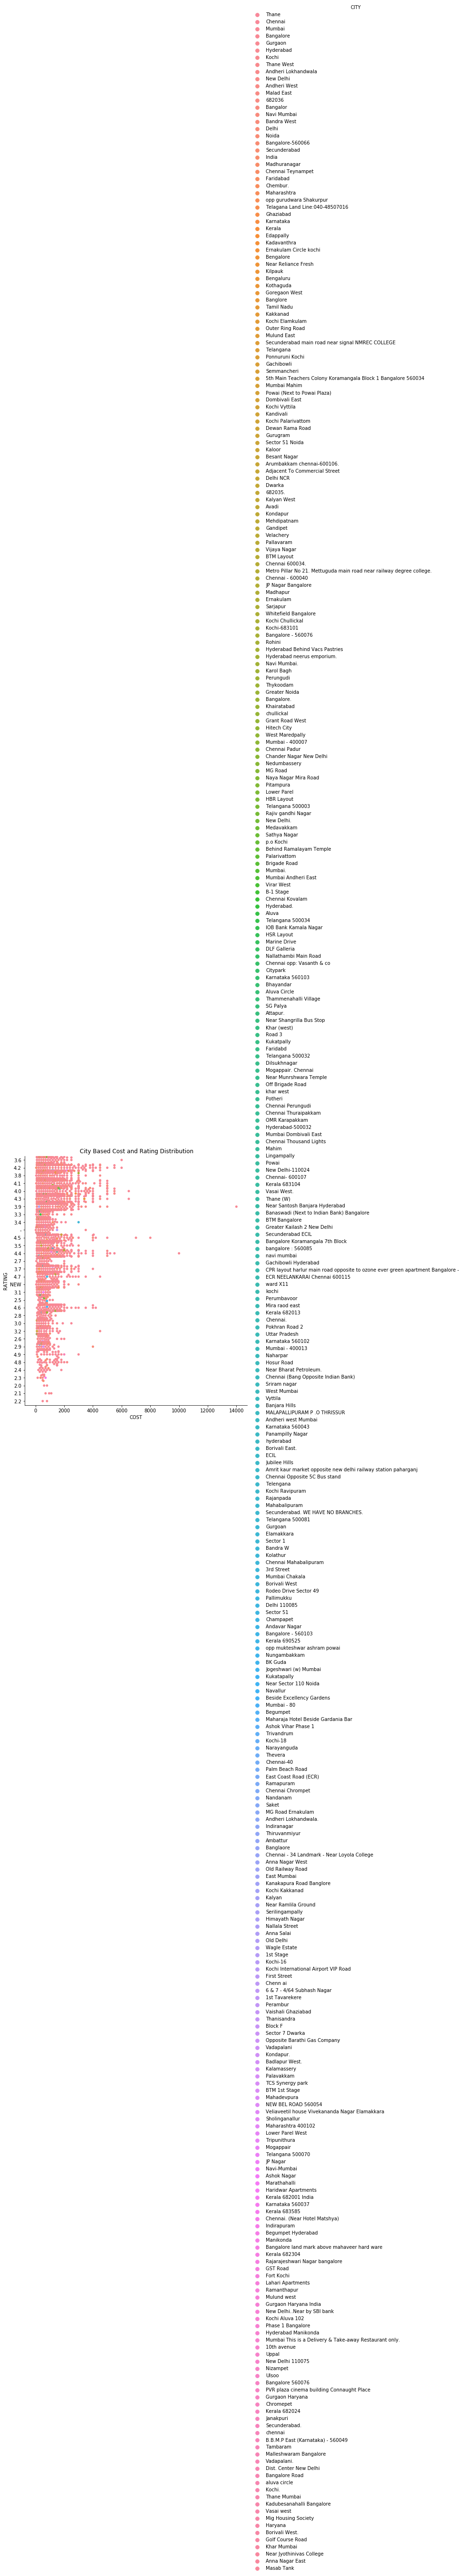

In [9]:
# Plot food cost and rating based on city. 
sns.catplot(x="COST", y="RATING", data=fdc_train, kind="swarm", 
            hue= 'CITY', height=8, aspect=1)
                                                     
plt.title(' City Based Cost and Rating Distribution') 
plt.show()

Majority of the indian cities food cost is below 4000Rs. 

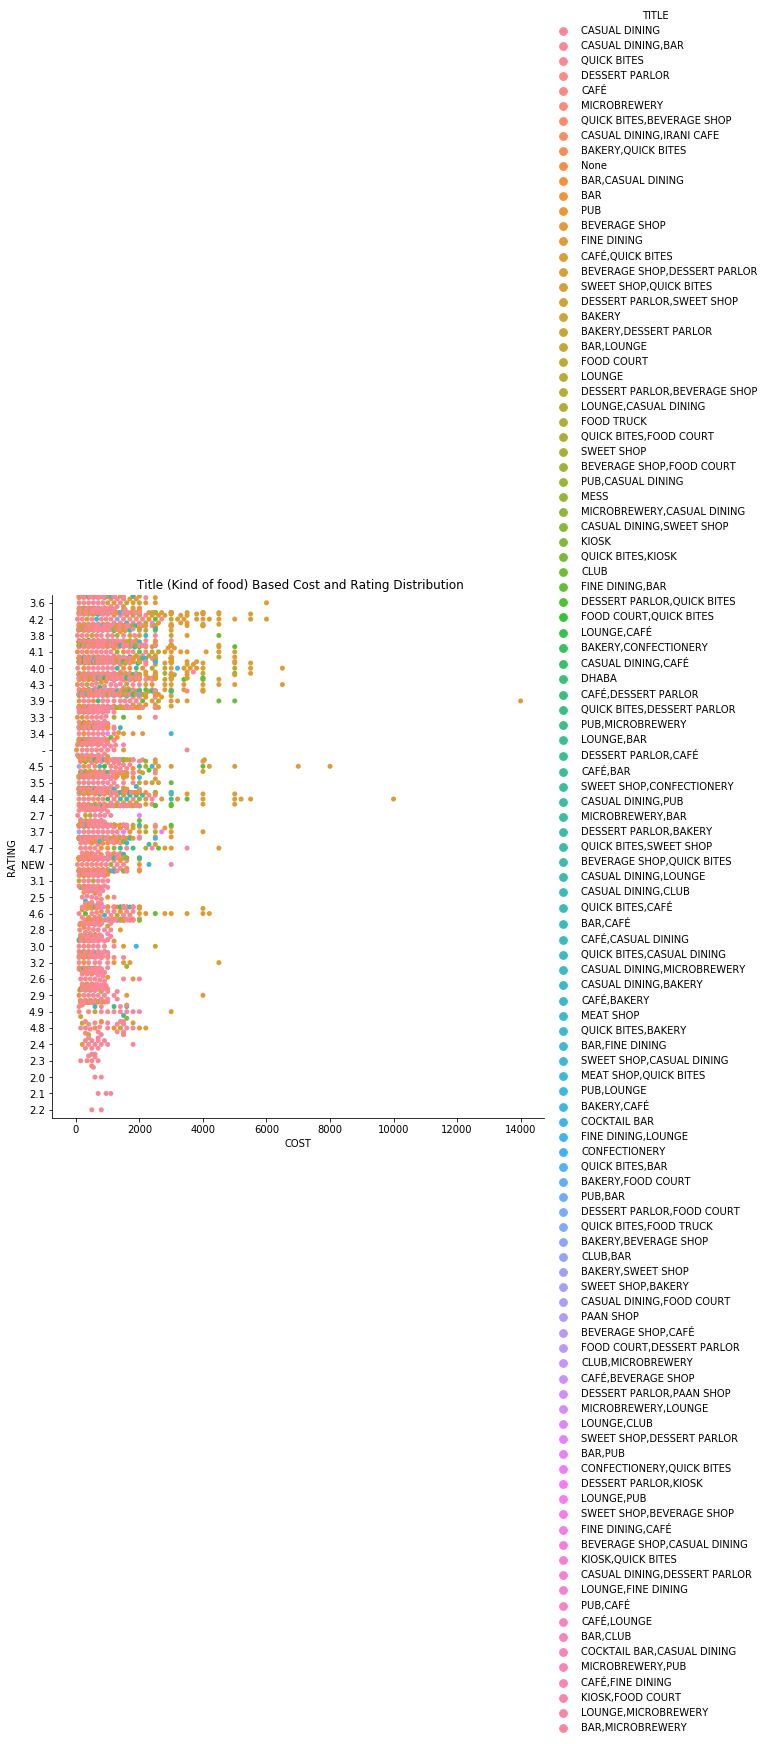

In [10]:
# Plot food cost and rating based on city. 
sns.catplot(x="COST", y="RATING", data=fdc_train, kind="swarm", 
            hue= 'TITLE', height=8, aspect=1)
                                                     
plt.title(' Title (Kind of food) Based Cost and Rating Distribution') 
plt.show()

Casual dining, casual bar, dessert are under 2000Rs. Majority of the food title are under 2500Rs. 

In [11]:
# merge train and test dataset 
fdc_df = fdc_train.append(fdc_test,ignore_index=True)

In [12]:
fdc_df = fdc_df[['TITLE', 'CUISINES', 'TIME', 'CITY', 'LOCALITY', 'RATING', 'VOTES', 'COST']]

In [13]:
fdc_df['VOTES'] = fdc_df['VOTES'].str.replace(' votes', '').astype(float)

In [14]:
fdc_df['RATING'] = fdc_df['RATING'].str.replace('NEW', '1')
fdc_df['RATING'] = fdc_df['RATING'].str.replace('-', '1').astype(float)

In [15]:
fdc_df['COST'] = fdc_df['COST'].astype(float)

In [16]:
fdc_df.mean()

RATING      3.520790
VOTES     419.194254
COST      655.252246
dtype: float64

In [17]:
fdc_df['CITY'].fillna('Missing', inplace=True)  
fdc_df['LOCALITY'].fillna('Missing', inplace=True)  
fdc_df['RATING'].fillna(3.5, inplace=True)  
fdc_df['VOTES'].fillna(419, inplace=True)
fdc_df['COST'].fillna(655.25, inplace=True)

In [18]:
tf1 = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
fdc_df_title = tf1.fit_transform(fdc_df['TITLE'])
fdc_df_title = pd.DataFrame(data=fdc_df_title.toarray(), columns=tf1.get_feature_names())

tf2 = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
fdc_df_cuisines = tf2.fit_transform(fdc_df['CUISINES'])
fdc_df_cuisines = pd.DataFrame(data=fdc_df_cuisines.toarray(), columns=tf2.get_feature_names())

tf3 = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
fdc_df_city = tf3.fit_transform(fdc_df['CITY'])
fdc_df_city = pd.DataFrame(data=fdc_df_city.toarray(), columns=tf3.get_feature_names())

tf4 = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
fdc_df_locality = tf4.fit_transform(fdc_df['LOCALITY'])
fdc_df_locality = pd.DataFrame(data=fdc_df_locality.toarray(), columns=tf4.get_feature_names())

tf5 = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
fdc_df_time = tf5.fit_transform(fdc_df['TIME'])
fdc_df_time = pd.DataFrame(data=fdc_df_time.toarray(), columns=tf5.get_feature_names())

In [19]:
fdc_df = pd.concat([fdc_df, fdc_df_title, fdc_df_cuisines, fdc_df_city, fdc_df_locality, fdc_df_time], axis=1) 
fdc_df.drop(['TITLE', 'CUISINES', 'CITY', 'LOCALITY', 'TIME'], axis=1, inplace=True)

In [20]:
fdc_df.head()

,RATING,VOTES,COST,bakery,bar,beverage,bhojanalya,bites,cafe,café,...,closed,fri,hours,mon,not,sat,sun,thu,tue,wed
0,3.6,49.0,1200.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.141835,0.0,0.0,0.149148,0.0,0.0,0.0
1,4.2,30.0,1500.0,0.0,0.808335,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.195361,0.0,0.0,0.205434,0.0,0.0,0.0
2,3.8,221.0,800.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.187987,0.0,0.0,0.197680,0.0,0.0,0.0
3,4.1,24.0,800.0,0.0,0.000000,0.0,0.0,0.707107,0.0,0.0,...,0.0,0.0,0.0,0.182108,0.0,0.0,0.191498,0.0,0.0,0.0
4,3.8,165.0,300.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.214553,0.0,0.0,0.225616,0.0,0.0,0.0


In [21]:
fdc_df = pd.get_dummies(fdc_df, columns=['closed'], drop_first=True)

In [22]:
fdc_df.head()

,RATING,VOTES,COST,bakery,bar,beverage,bhojanalya,bites,cafe,café,...,closed_0.6243643196521643,closed_0.6303718976409675,closed_0.6318174617042887,closed_0.636770724133859,closed_0.6385470409826283,closed_0.640049714154265,closed_0.6402092029306706,closed_0.64201453296073,closed_0.6435418778918051,closed_0.6482517280229787
0,3.6,49.0,1200.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,4.2,30.0,1500.0,0.0,0.808335,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3.8,221.0,800.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4.1,24.0,800.0,0.0,0.000000,0.0,0.0,0.707107,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,3.8,165.0,300.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
fdc_df.shape

(16921, 2622)

In [24]:
for col in fdc_df.columns:
    print("Count of NAN values in", col, fdc_df[col].isna().sum())

Count of NAN values in RATING 0
Count of NAN values in VOTES 0
Count of NAN values in COST 0
Count of NAN values in bakery bakery    0
bakery    0
dtype: int64
Count of NAN values in bar bar    0
bar    0
bar    0
bar    0
dtype: int64
Count of NAN values in beverage 0
Count of NAN values in bhojanalya 0
Count of NAN values in bites 0
Count of NAN values in cafe cafe    0
cafe    0
cafe    0
dtype: int64
Count of NAN values in café 0
Count of NAN values in casual 0
Count of NAN values in club club    0
club    0
dtype: int64
Count of NAN values in cocktail 0
Count of NAN values in confectionery 0
Count of NAN values in court court    0
court    0
dtype: int64
Count of NAN values in dessert 0
Count of NAN values in dhaba 0
Count of NAN values in dining 0
Count of NAN values in fine 0
Count of NAN values in food food    0
food    0
food    0
dtype: int64
Count of NAN values in irani 0
Count of NAN values in kiosk 0
Count of NAN values in lounge 0
Count of NAN values in meat 0
Count of NA

Count of NAN values in anna anna    0
anna    0
dtype: int64
Count of NAN values in apartment apartment    0
apartment    0
dtype: int64
Count of NAN values in apartments 0
Count of NAN values in apr 0
Count of NAN values in area area    0
area    0
dtype: int64
Count of NAN values in arumbakkam arumbakkam    0
arumbakkam    0
dtype: int64
Count of NAN values in ashok ashok    0
ashok    0
dtype: int64
Count of NAN values in ashram ashram    0
ashram    0
dtype: int64
Count of NAN values in attapur attapur    0
attapur    0
dtype: int64
Count of NAN values in avadi avadi    0
avadi    0
dtype: int64
Count of NAN values in avenue avenue    0
avenue    0
dtype: int64
Count of NAN values in away 0
Count of NAN values in badlapur 0
Count of NAN values in bagh bagh    0
bagh    0
dtype: int64
Count of NAN values in balavinayagar 0
Count of NAN values in banaswadi banaswadi    0
banaswadi    0
dtype: int64
Count of NAN values in bandra bandra    0
bandra    0
dtype: int64
Count of NAN values

Count of NAN values in matshya 0
Count of NAN values in medavakkam medavakkam    0
medavakkam    0
dtype: int64
Count of NAN values in mehdipatnam mehdipatnam    0
mehdipatnam    0
dtype: int64
Count of NAN values in metro metro    0
metro    0
dtype: int64
Count of NAN values in mettuguda mettuguda    0
mettuguda    0
dtype: int64
Count of NAN values in mg mg    0
mg    0
dtype: int64
Count of NAN values in mig 0
Count of NAN values in mira mira    0
mira    0
dtype: int64
Count of NAN values in missing missing    0
missing    0
dtype: int64
Count of NAN values in miumbai 0
Count of NAN values in mm 0
Count of NAN values in mogappair mogappair    0
mogappair    0
dtype: int64
Count of NAN values in mohammad mohammad    0
mohammad    0
dtype: int64
Count of NAN values in mukteshwar mukteshwar    0
mukteshwar    0
dtype: int64
Count of NAN values in mulund mulund    0
mulund    0
dtype: int64
Count of NAN values in mumbai mumbai    0
mumbai    0
dtype: int64
Count of NAN values in mumbr

Count of NAN values in 31 0
Count of NAN values in 32 0
Count of NAN values in 33 0
Count of NAN values in 34 34    0
34    0
dtype: int64
Count of NAN values in 35 0
Count of NAN values in 359 0
Count of NAN values in 37 37    0
37    0
dtype: int64
Count of NAN values in 3794 0
Count of NAN values in 38 0
Count of NAN values in 38a 0
Count of NAN values in 39 0
Count of NAN values in 393 0
Count of NAN values in 3rd 3rd    0
3rd    0
dtype: int64
Count of NAN values in 400013 400013    0
400013    0
dtype: int64
Count of NAN values in 402b 0
Count of NAN values in 41 0
Count of NAN values in 42 0
Count of NAN values in 43 0
Count of NAN values in 44 0
Count of NAN values in 45 0
Count of NAN values in 46 0
Count of NAN values in 47 0
Count of NAN values in 49 49    0
49    0
dtype: int64
Count of NAN values in 4th 0
Count of NAN values in 50 0
Count of NAN values in 500001 0
Count of NAN values in 500025 0
Count of NAN values in 500047 0
Count of NAN values in 500053 0
Count of NAN v

Count of NAN values in cashire 0
Count of NAN values in castle 0
Count of NAN values in cbd 0
Count of NAN values in center center    0
center    0
dtype: int64
Count of NAN values in central 0
Count of NAN values in centre centre    0
centre    0
dtype: int64
Count of NAN values in cesz 0
Count of NAN values in chakala chakala    0
chakala    0
dtype: int64
Count of NAN values in chakkar 0
Count of NAN values in chambers chambers    0
chambers    0
dtype: int64
Count of NAN values in champapet champapet    0
champapet    0
dtype: int64
Count of NAN values in chanakyapuri 0
Count of NAN values in chanda 0
Count of NAN values in chandavarkar 0
Count of NAN values in chander chander    0
chander    0
dtype: int64
Count of NAN values in chandivali 0
Count of NAN values in chandni 0
Count of NAN values in chandra 0
Count of NAN values in chandras 0
Count of NAN values in chandrayanagutta 0
Count of NAN values in chandrayangutta 0
Count of NAN values in channasandra 0
Count of NAN values in

Count of NAN values in heights 0
Count of NAN values in hennur 0
Count of NAN values in high 0
Count of NAN values in hill 0
Count of NAN values in hills hills    0
hills    0
dtype: int64
Count of NAN values in himayath himayath    0
himayath    0
dtype: int64
Count of NAN values in hiranandani 0
Count of NAN values in hitech hitech    0
hitech    0
dtype: int64
Count of NAN values in hmt 0
Count of NAN values in hobli 0
Count of NAN values in homes 0
Count of NAN values in hoshiyarpur 0
Count of NAN values in hospital 0
Count of NAN values in hosur hosur    0
hosur    0
dtype: int64
Count of NAN values in hotel hotel    0
hotel    0
dtype: int64
Count of NAN values in house house    0
house    0
dtype: int64
Count of NAN values in houz 0
Count of NAN values in hs 0
Count of NAN values in hsr hsr    0
hsr    0
dtype: int64
Count of NAN values in huda 0
Count of NAN values in hussain 0
Count of NAN values in hyder 0
Count of NAN values in hyderabad hyderabad    0
hyderabad    0
dtype: 

Count of NAN values in mall mall    0
mall    0
dtype: int64
Count of NAN values in mallapur 0
Count of NAN values in malleshwaram malleshwaram    0
malleshwaram    0
dtype: int64
Count of NAN values in malleswaram 0
Count of NAN values in malleswraram 0
Count of NAN values in mallika 0
Count of NAN values in malviya 0
Count of NAN values in malwani malwani    0
malwani    0
dtype: int64
Count of NAN values in mamallapuram 0
Count of NAN values in mamangalam 0
Count of NAN values in mambalam 0
Count of NAN values in mandal 0
Count of NAN values in mandaveli 0
Count of NAN values in mandi 0
Count of NAN values in mandir 0
Count of NAN values in maniammai 0
Count of NAN values in manikeswari 0
Count of NAN values in manikonda manikonda    0
manikonda    0
dtype: int64
Count of NAN values in manikpur 0
Count of NAN values in manjapetty 0
Count of NAN values in manjeera 0
Count of NAN values in manpada 0
Count of NAN values in mansingh 0
Count of NAN values in manzil 0
Count of NAN values 

Count of NAN values in pragati 0
Count of NAN values in prasanth 0
Count of NAN values in prashant 0
Count of NAN values in pratap 0
Count of NAN values in pravasi 0
Count of NAN values in preet 0
Count of NAN values in private 0
Count of NAN values in properties 0
Count of NAN values in ptk 0
Count of NAN values in pukalakkatt 0
Count of NAN values in pukkattupadi 0
Count of NAN values in pump 0
Count of NAN values in punjabi 0
Count of NAN values in puram puram    0
puram    0
dtype: int64
Count of NAN values in purasaiwakkam 0
Count of NAN values in purasaiwalkam 0
Count of NAN values in purasavakkam 0
Count of NAN values in puri 0
Count of NAN values in puthiya 0
Count of NAN values in puthukalavattom 0
Count of NAN values in pvr pvr    0
pvr    0
dtype: int64
Count of NAN values in pwd 0
Count of NAN values in quarters 0
Count of NAN values in qutab 0
Count of NAN values in ra ra    0
ra    0
dtype: int64
Count of NAN values in race 0
Count of NAN values in racecourse 0
Count of N

Count of NAN values in thrippunithura 0
Count of NAN values in thuraipakkam thuraipakkam    0
thuraipakkam    0
dtype: int64
Count of NAN values in tikona 0
Count of NAN values in tila 0
Count of NAN values in tilak 0
Count of NAN values in time 0
Count of NAN values in tippasandra 0
Count of NAN values in tirupati 0
Count of NAN values in tiruvanadapuram 0
Count of NAN values in tiruvottiyur 0
Count of NAN values in tkr 0
Count of NAN values in to to    0
to    0
dtype: int64
Count of NAN values in toli 0
Count of NAN values in tolichowki tolichowki    0
tolichowki    0
dtype: int64
Count of NAN values in toll 0
Count of NAN values in tower 0
Count of NAN values in town 0
Count of NAN values in trimulgherry 0
Count of NAN values in triplicane 0
Count of NAN values in tripunithura tripunithura    0
tripunithura    0
dtype: int64
Count of NAN values in tughlakabad 0
Count of NAN values in turbe 0
Count of NAN values in uday 0
Count of NAN values in udayapura 0
Count of NAN values in udy

Count of NAN values in closed_0.41965525271960535 0
Count of NAN values in closed_0.41989979783583303 0
Count of NAN values in closed_0.42152501137517523 0
Count of NAN values in closed_0.4228266629383171 0
Count of NAN values in closed_0.4236975526288275 0
Count of NAN values in closed_0.42445905889695196 0
Count of NAN values in closed_0.4267695151065423 0
Count of NAN values in closed_0.4274785855973147 0
Count of NAN values in closed_0.42767896839144026 0
Count of NAN values in closed_0.42932105261324527 0
Count of NAN values in closed_0.43027751508470435 0
Count of NAN values in closed_0.4307105879419702 0
Count of NAN values in closed_0.43176607289646624 0
Count of NAN values in closed_0.43266669070658953 0
Count of NAN values in closed_0.43283657313073604 0
Count of NAN values in closed_0.4330495742462953 0
Count of NAN values in closed_0.4341566976260017 0
Count of NAN values in closed_0.4341611304149584 0
Count of NAN values in closed_0.43460112978302207 0
Count of NAN values 

Count of NAN values in closed_0.640049714154265 0
Count of NAN values in closed_0.6402092029306706 0
Count of NAN values in closed_0.64201453296073 0
Count of NAN values in closed_0.6435418778918051 0
Count of NAN values in closed_0.6482517280229787 0


In [25]:
fdc_df['COST'] = np.log1p(fdc_df['COST'])

In [26]:
# Let's split the data into train and test.
x= fdc_df.drop(labels=['COST'], axis=1)
y= fdc_df['COST'].values

x_, x_test, y_, y_test = train_test_split(x,y,test_size=0.25,train_size=0.75)
x_train, x_val, y_train, y_val = train_test_split(x_,y_,test_size = 0.25,train_size =0.75)

In [27]:
x_train.shape, x_test.shape

((9517, 2621), (4231, 2621))

In [28]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((9517, 2621), (3173, 2621), (9517,), (3173,))

Train and Validate Random Forest Regressor 

In [29]:
RandomForest = RandomForestRegressor(n_estimators=42, criterion='mse', max_depth=None, min_samples_split=5, min_samples_leaf=4, 
                           min_weight_fraction_leaf=0.001, max_features='auto', max_leaf_nodes=None, 
                           min_impurity_decrease=0.001, min_impurity_split=None, bootstrap=True, oob_score=False, 
                           random_state=42, verbose=1, warm_start=False)
RandomForest.fit(x_train, y_train)
y_pred_rf = RandomForest.predict(x_val)
print('RMSLE:', sqrt(mean_squared_log_error(np.exp(y_val), np.exp(y_pred_rf))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RMSLE: 0.44648283789958076


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    0.0s finished


Train and Validate Bagging Regressor

In [30]:
Bagging = BaggingRegressor(base_estimator=None, n_estimators=30, max_samples=0.9, max_features=1.0, bootstrap=True, 
                      bootstrap_features=True, oob_score=True, warm_start=False, n_jobs=1, random_state=42, verbose=1)
Bagging.fit(x_train, y_train)
y_pred_br = Bagging.predict(x_val)
print('RMSLE:', sqrt(mean_squared_log_error(np.exp(y_val), np.exp(y_pred_br))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RMSLE: 0.4421661847526382


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


Lets predict on test data set 

In [31]:
y_pred_price_Forest =  RandomForest.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    0.0s finished


In [32]:
y_pred_price_Bagging =  Bagging.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


In [33]:
# Lets perform the inverse of the log transform 
Forest_final = np.exp(y_pred_price_Forest)
Bagging_final = np.exp(y_pred_price_Bagging)

In [34]:
print("Price predictions of Random Forest Regressor: \n",Forest_final)
print('\n')
print("Price predictions of Bagging Regressor: \n",Bagging_final)

Price predictions of Random Forest Regressor: 
 [369.10565022 359.45926013 693.89924585 ... 400.50981744 699.96243222
 543.3040217 ]


Price predictions of Bagging Regressor: 
 [433.38630233 358.19643823 724.3486391  ... 325.29992836 605.85038611
 535.82535549]


In [35]:
FoodCost = pd.DataFrame(data=Bagging_final, columns=['Food Cost'])
writer = pd.ExcelWriter('Foodcost.xlsx', engine='xlsxwriter')
FoodCost.to_excel(writer,sheet_name='Sheet1', index=False)
writer.save()